# Twitter disaster response messages

## 1. Introduction

The dataset is made available by [Figure Eight](https://www.figure-eight.com) and it comprises a set of messages related to disaster response, covering multiple languages, suitable for text categorization and related natural language processing tasks.


As described [here](https://www.figure-eight.com/dataset/combined-disaster-response-data/), this dataset contains 30,000 messages drawn from events including an earthquake in Haiti in 2010, an earthquake in Chile in 2010, floods in Pakistan in 2010, super-storm Sandy in the U.S.A. in 2012, and news articles spanning a large number of years and 100s of different disasters. The data has been encoded with 36 different categories related to disaster response and has been stripped of messages with sensitive information in their entirety.

Upon release, this is the featured dataset of a new Udacity course on Data Science and the AI4ALL summer school and is especially utile for text analytics and natural language processing (NLP) tasks and models.


### 1.1 Problem Assessment and Goal

The goal is to train a classifier able to detect different emergencies or disaster situations.

The problem is challenging because:
* disasters are infrequent events, hence the classes are imbalanced
* there are many misspellings in the messages and frequent use of foreign terms
* some emergency categories (e.g. `child alone`) are not represented in the training data

In this case we limit ourselves to sketching a proof of concept, rather than presenting a full solution. 

For example, although the problem is multi-class we focus on predicting a single class (`food`)

We compare an approach based on word frequency (TFIDF) with an approach based on word embeddings and neural networks (through the [SpaCy](https://spacy.io/) library).




In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import random as rd

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.util import minibatch, compounding

import re
import urllib.request
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

nlp = spacy.load("en_core_web_md")

from spacy import displacy

In [38]:
from sklearn.base import TransformerMixin


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix

import sklearn.metrics as met
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from scipy.stats import randint as sp_randint , uniform


In [36]:
# download data files

if 0:
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_training.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_training.csv')
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_test.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_test.csv')
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_validation.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_validation.csv')
    
def plot_roc_mat(y_test,res):

    for name,y_score in res.items():
#         y_score=df.loc[n,'y_score']
#         name=df.loc[n,'model'] 

        fpr, tpr, thresholds = roc_curve(y_test,  y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=1, label='%s (AUC = %0.2f)' % (name,roc_auc));
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                   label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR = FP/(FP+TN)')
    plt.ylabel('TPR = Recall = (TP/(TP+FN)) ')
    plt.title('ROC viewed')
    plt.legend(loc="lower right");
    plt.axis('square');

In [221]:
def transform_sentence(bow, message):
    # for eli5
    
    print("original: ",message)
    
    words=np.array(bow.get_feature_names())
    TR=bow.transform([ message ])
    g,ind=TR.nonzero()
    transformed=",".join(words[ind]) 
    print("transformed: ",transformed)
    print()
    

In [4]:
df=pd.read_csv('disaster_response_messages_training.csv')
df=df.drop(columns=['original','split'])

test_df=pd.read_csv('disaster_response_messages_test.csv')
test_df=test_df.drop(columns=['original','split'])

valid_df=pd.read_csv('disaster_response_messages_validation.csv')
valid_df=valid_df.drop(columns=['original','split'])



C:\anaconda3\envs\ds\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.iloc[:,:10].head()

,id,message,genre,related,PII,request,offer,aid_related,medical_help,medical_products
0,2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,direct,1,0,0,0,1,0,0
2,12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0
3,14,Information about the National Palace-,direct,0,0,0,0,0,0,0
4,15,Storm at sacred heart of jesus,direct,1,0,0,0,0,0,0


number of messages:  21046


Text(0,0.5,'percentage positve')

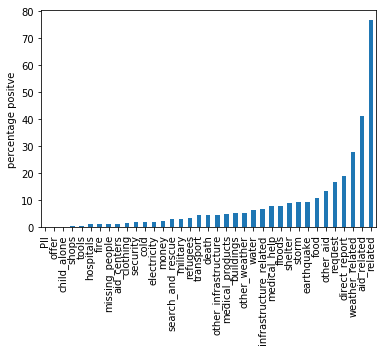

In [7]:
n_messages=df.shape[0]
print("number of messages: ",n_messages)

perc_positive=100.*df.iloc[:,3:].sum()/n_messages
perc_positive=perc_positive.sort_values()
perc_positive.plot(kind='bar');
plt.ylabel('percentage positve')


In [8]:
display(df['message'].to_frame().head(10))

,message
0,Weather update - a cold front from Cuba that could pass over Haiti
1,Is the Hurricane over or is it not over
2,"says: west side of Haiti, rest of the country today and tonight"
3,Information about the National Palace-
4,Storm at sacred heart of jesus
5,"Please, we need tents and water. We are in Silo, Thank you!"
6,"I would like to receive the messages, thank you"
7,"There's nothing to eat and water, we starving and thirsty."
8,I am in Petionville. I need more information regarding 4636
9,"I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks"


## 2 Bag-of-words model

The [Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW) is a text classification approach that discards grammar and word order but focuses only on relative term frequency in a corpus of documents. 
First the corpus of messages is scanned and the mose representative words selected. Then the count of their occurrences in the messages is recorded in a sparse matrix that is processed by the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) algorithm.

The basic idea is that a message about food will have a higher frequency of food related words than a message about storms.
So a classifier can be trained to recognize the topic of the messages depending on the relative frequency of the words.


### 2.1 Preprocessing

Preprocessing is crucial: choosing the wrong words will significantly degrade the performance of the model.

The CountVectorizer tool is used to extract the most relevant (typically the most frequently used) words.

If we use the CountVectorizer function naively naively, we observe that:
* commond words with little predicted value (and, like, be, but ...) are included.
* names of countries, cities and nationalities may also included

In [9]:
bow = CountVectorizer(max_features=1000,)
bow.fit(df.loc[0:1000,'message'])
print(bow.get_feature_names()[0:100])


['10', '11', '12', '12th', '15', '150', '16', '18', '19', '20', '200', '2000', '2010', '22', '23', '24', '27', '29', '30', '31', '32', '33', '35', '37', '3rd', '40', '41', '42', '43', '4636', '48', '4th', '50', '500', '52', '54', '600', '75', '79', '87', 'able', 'about', 'abroad', 'academy', 'access', 'account', 'across', 'action', 'actually', 'address', 'adopt', 'adress', 'advance', 'advertising', 'advise', 'after', 'afternoon', 'aftershake', 'aftershock', 'aftershocks', 'again', 'aid', 'aide', 'aids', 'airport', 'airtime', 'alerte', 'alexandre', 'alive', 'all', 'almost', 'alone', 'along', 'alot', 'already', 'also', 'always', 'am', 'ambroise', 'american', 'americans', 'an', 'and', 'another', 'anse', 'answer', 'antoine', 'any', 'anymore', 'anyone', 'anything', 'aquin', 'are', 'area', 'areas', 'aren', 'army', 'around', 'arrived', 'artibonit']


To prevent such issues and in the interest of efficiency, we use a more sophisticated tokenizer (based on SpaCy) that can:
* remove common English stop words
* remove Named Entities such as countries, cities, organizations etc

In [10]:
doc = nlp("I am planning to travel to Paris on Monday with George to visit the Louvre. Unfortunately I don't speak French well.")
displacy.render(doc, style="ent")

In [11]:
def spacy_tokenizer(message):
    message=re.sub("[1-9#@$'!*+%\".()!,]?;",'',message).replace('','').replace('-','')
    message=' '.join(message.split())
    doc=nlp(message)
    words=[]

    remove_ent=[]
    for ent in doc.ents:
        if ent.label_ in ['GPE','LOC','NORP','FAC','ORG','LANGUAGE']:
            remove_ent.append(ent.text)

    # remove punctuation etc
    for token in doc:
        if ( (~token.is_stop)   & (token.pos_!='NUM') & (token.pos_!='PUNCT') & (token.pos_!='SYM') &
           ~(token.text in (remove_ent)) & (len(token.text)>1) ):
            words.append(token.text)
    return(words)



In [12]:
bow = CountVectorizer(tokenizer = spacy_tokenizer, max_df=0.9,min_df=3, max_features=1000)
bow.fit(df.loc[0:1000,'message'])
# bow.fit(df.loc[df.food==1,'message'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=1000, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x000000004B577BF8>,
                vocabulary=None)

In [19]:
print(bow.get_feature_names()[0:50])

['12th', '3rd', '4th', 'able', 'abroad', 'access', 'address', 'adress', 'advance', 'afternoon', 'aftershake', 'aftershock', 'aftershocks', 'aid', 'aide', 'airport', 'alive', 'alot', 'answer', 'antoine', 'anymore', 'aquin', 'area', 'areas', 'arrived', 'artibonite', 'ask', 'asking', 'assistance', 'association', 'attention', 'au', 'aucun', 'authorities', 'available', 'avenue', 'away', 'b.', 'baby', 'bad', 'beach', 'bertin', 'besoin', 'better', 'big', 'bless', 'bodies', 'body', 'bois', 'bon']


We note that in the second case the words selected appear more useful.

In general it is highly recommended to check the quality words choosen by the algorithm:
* for a small subset of messages to catch obvious issues (too many numbers, ...)
* on the positive disaster messages on a few classes to see if obvious trigger words are identified

We note that if the bag of words is too small we risk to miss important words (especially in the case of imbalanced classes).
Conversely if the bag of words is too big, the time needed to fit the model will increase.



## 2.2 Classification

After choosing the parameters for the CountVectorizer and TfidfTransformer algorithms we split the data into a test and training portion.
We will compare the results of different classification algorithms.


In [13]:
# X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['food'], test_size=0.2)
X_train=df['message']
Y_train=df['food']

X_test=test_df['message']
Y_test=test_df['food']

X_valid=valid_df['message']
Y_valid=valid_df['food']

In [14]:
bow = CountVectorizer(tokenizer = spacy_tokenizer, max_df=0.9,min_df=2, max_features=10000)
bow.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=10000, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x000000004B577BF8>,
                vocabulary=None)

In [15]:
X_train_cv = bow.transform(X_train)
tfidf = TfidfTransformer()
tfidf.fit(X_train_cv)
X_train_tdidf = tfidf.transform(X_train_cv)


In [16]:
X_test_cv = bow.transform(X_test)
X_test_tdidf = tfidf.transform(X_test_cv)

In [17]:
X_valid_cv = bow.transform(X_valid)
X_valid_tdidf = tfidf.transform(X_valid_cv)

#### 2.2.1 LogisticRegression Classifier

In [294]:

model = Pipeline([
        ('clf', LogisticRegression(random_state=0, solver='liblinear',penalty='l1',max_iter=200,class_weight='balanced',
                                   )  ),
    ])
parameters = {
    'clf__C': uniform(.001, 1),
}

cv_folds = 5

scorerAP = make_scorer(met.average_precision_score, greater_is_better=True)
cv = RandomizedSearchCV(model, scoring=scorerAP, param_distributions=parameters, verbose=1, cv=cv_folds, refit='AP')

cv.fit(X_train_tdidf,Y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.5s finished


In [307]:
clf=cv.best_estimator_.steps[0][1]
# y_pred=clf.predict(X_test_tdidf)
y_pred=clf.predict(X_valid_tdidf)
y_score = clf.predict_proba(X_valid_tdidf)[:,1]

res={'LR':y_score}
# res['LR']=y_score


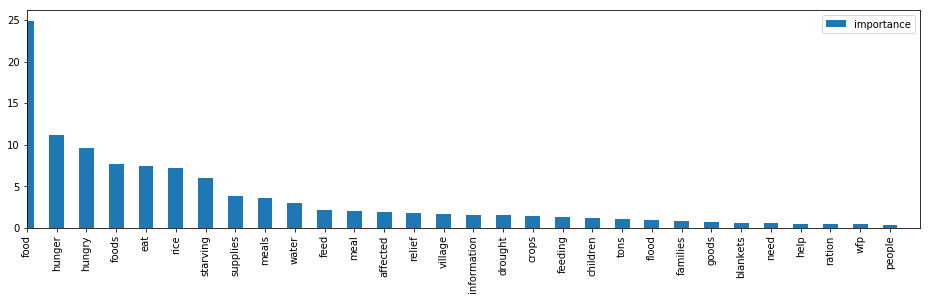

In [313]:
plot_feature_importance_bow_lr(clf,bow,figsize=(16,4),n_features=30)

In [83]:
print(classification_report(Y_valid.values, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2298
           1       0.70      0.84      0.76       275

    accuracy                           0.94      2573
   macro avg       0.84      0.90      0.87      2573
weighted avg       0.95      0.94      0.95      2573



In [84]:
display(pd.DataFrame( confusion_matrix(Y_valid,y_pred),columns=['y_pred 0','y_pred 1'],index=['y_true 0','y_true 1'] ) )

,y_pred 0,y_pred 1
y_true 0,2200,98
y_true 1,44,231


In [245]:
n=3
transform_sentence(bow, valid_df.loc[n,'message'])
show_prediction(clf.steps[0][1],  valid_df.loc[n,'message'], vec=bow , target_names=[0,1])

original:  People I'm at Delma 2, we don't anything what so ever, please provide us with some food, water, and medicine
transformed:  delma,food,medicine,people,provide,water



In [246]:
# n=11
n=25

transform_sentence(bow, valid_df.loc[n,'message'])
show_prediction(clf.steps[0][1],  valid_df.loc[n,'message'], vec=bow , target_names=[0,1])

original:  No one can buy anything. Tiny amounts of rice are being sold at 350 dollars. Hunger is gonna finish us off. I come from la Gonave. I live in the second communal section of ville anse a galets. I have a ( incomplete )
transformed:  amounts,anse,buy,come,communal,dollars,finish,galets,gon,gonave,hunger,incomplete,la,live,na,rice,second,section,sold,tiny,ville



#### 2.2.2 Random Forest Classifier

In [236]:
param_dist = {
              "n_estimators": sp_randint(1, 200),
              "max_depth": sp_randint(1, 5),
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 100
rf_clf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
cv = RandomizedSearchCV(rf_clf,scoring='average_precision', param_distributions=param_dist,  cv=5, iid=False,  n_iter=n_iter_search, n_jobs=4)

cv.fit(X_train_tdidf,Y_train);

In [238]:
rf_clf=cv.best_estimator_
y_pred=rf_clf.predict(X_valid_tdidf)
y_score = rf_clf.predict_proba(X_valid_tdidf)[:,1]

res['RF']=y_score

In [239]:
print(classification_report(Y_valid.values, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      2298
           1       0.55      0.77      0.64       275

    accuracy                           0.91      2573
   macro avg       0.76      0.85      0.79      2573
weighted avg       0.93      0.91      0.91      2573



In [240]:
display(pd.DataFrame( confusion_matrix(Y_valid,y_pred),columns=['y_pred 0','y_pred 1'],index=['y_true 0','y_true 1'] ) )

,y_pred 0,y_pred 1
y_true 0,2125,173
y_true 1,63,212


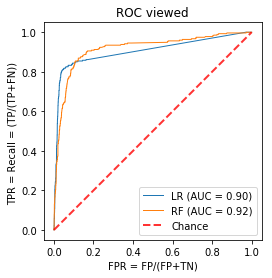

In [241]:
plot_roc_mat(Y_valid,res)

In [300]:
def plot_feature_importance_bow(clf,bow,figsize=(16,4),n_features=30):
    # plots the feature important for the classifier clf
    feat=pd.DataFrame.from_dict(dict(zip(bow.get_feature_names(),clf.feature_importances_) ), orient='index',columns=['importance'])
    feat=feat.sort_values(by=['importance'],ascending=False)

    feat.iloc[0:n_features].plot(kind='bar',figsize=figsize);
    plt.xlim(0,n_features);

In [312]:
def plot_feature_importance_bow_lr(clf,bow,figsize=(16,4),n_features=30):
    # plots the feature important for the classifier clf
    feature_importances=np.abs(clf.coef_[0])
#     print(feature_importances)
    feat=pd.DataFrame.from_dict(dict(zip(bow.get_feature_names(),feature_importances) ), orient='index',columns=['importance'])
    feat=feat.sort_values(by=['importance'],ascending=False)

    feat.iloc[0:n_features].plot(kind='bar',figsize=figsize);
    plt.xlim(0,n_features);

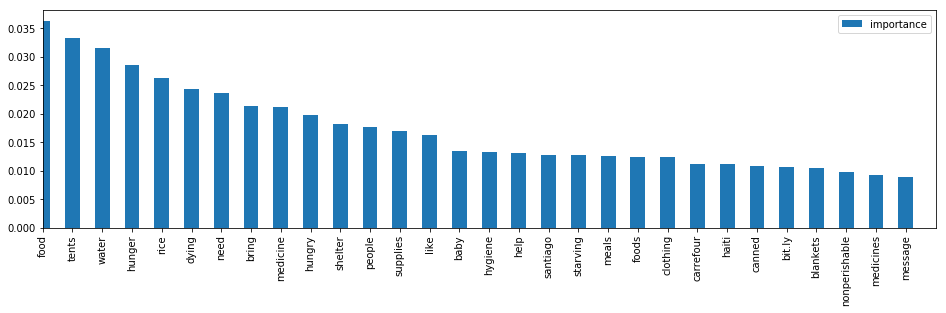

In [301]:
plot_feature_importance_bow(rf_clf,bow,figsize=(16,4),n_features=30)


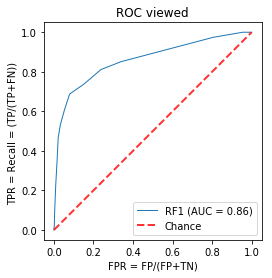

In [316]:
rf1_clf = RandomForestClassifier(  criterion="entropy",class_weight="balanced", n_estimators=20)
rf1_clf.fit(X_train_tdidf[0:100],Y_train[0:100]);

y_score = rf1_clf.predict_proba(X_valid_tdidf)[:,1]
plot_roc_mat(Y_valid,{'RF1':y_score})


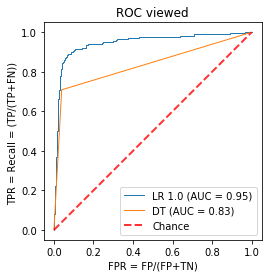

In [270]:
rf1_clf = LogisticRegression(random_state=0, C=1.0, solver='liblinear',penalty='l1',max_iter=200,class_weight='balanced')
rf1_clf.fit(X_train_tdidf,Y_train);
y_score = rf1_clf.predict_proba(X_valid_tdidf)[:,1]
tr={'LR 1.0':y_score}

# rf1_clf = LogisticRegression(random_state=0, C=1.0, solver='liblinear',penalty='l2',max_iter=200,class_weight='balanced')
rf1_clf =DecisionTreeClassifier(random_state=0,max_features=0.9)
rf1_clf.fit(X_train_tdidf,Y_train);
y_score = rf1_clf.predict_proba(X_valid_tdidf)[:,1]
tr['DT']=y_score

plot_roc_mat(Y_valid,tr)
                    
                    

In [277]:
np.nonzero(rf_clf.feature_importances_)[0].shape

(832,)

In [248]:
n=3
transform_sentence(bow, valid_df.loc[n,'message'])
show_prediction(rf_clf,  valid_df.loc[n,'message'], vec=bow , target_names=[0,1])

original:  People I'm at Delma 2, we don't anything what so ever, please provide us with some food, water, and medicine
transformed:  delma,food,medicine,people,provide,water



###  2.2.3 Gradient Boosted Decision Tree Classifier

In [28]:
import xgboost as xgb
from xgboost import XGBClassifier

params = {  
    "n_estimators": sp_randint(3, 40),
    "max_depth": sp_randint(3, 40),
    "learning_rate": uniform(0.05, 0.4),
    "gamma": uniform(0, 10),
}
# run randomized search
n_iter_search = 10
clf = XGBClassifier()
cv = RandomizedSearchCV(clf,scoring='average_precision', param_distributions=param_dist,  cv=5, iid=False,  n_iter=n_iter_search)

cv.fit(X_train_tdidf,Y_train);

In [40]:
clf=cv.best_estimator_
# y_pred=clf.predict(X_test_tdidf)
y_pred=clf.predict(X_valid_tdidf)
y_score = clf.predict_proba(X_valid_tdidf)[:,1]

res['XGB']=y_score


In [30]:
print(classification_report(Y_valid.values, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2298
           1       0.77      0.75      0.76       275

    accuracy                           0.95      2573
   macro avg       0.87      0.86      0.87      2573
weighted avg       0.95      0.95      0.95      2573



In [31]:
display(pd.DataFrame( confusion_matrix(Y_valid,y_pred),columns=['y_pred 0','y_pred 1'],index=['y_true 0','y_true 1'] ) )

,y_pred 0,y_pred 1
y_true 0,2235,63
y_true 1,68,207


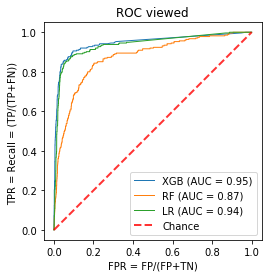

In [51]:
plot_roc_mat(Y_valid,res)

### 2.3 Conclusion

Given a good selection of words in the BOW model, the classifiers achieve reasonable results, especially considering that the classification is only based on the frequency of certain words.

Unsurprisingly, the LogisticRegressor classifier with L1 penalty performs better than algorithms based on the ensemble of trees.
The BOW model is very rich in features (10000 words), in order to capture the vocabulary of the corpus. 
However, it is quite likely that the most important keywords that identify a disaster event are very few. Therefore it's possible that unrelated words will receive small but non-null weights in the model. L1 Regularization forces these weights to zero and prevents overfitting the data. 


## 3. Word embedding approach

[Word embedding](https://en.wikipedia.org/wiki/Word_embedding) map words to vectors of fixed dimensionality (typically in the range of hundreds). The basic idea is to map similar words into similar vectors, so that relationship between words are mapped into geometrical relationships.

Advantages of word embedding models are:
* ability to deal with synonyms and misspelling
* some insight into the meaning of concepts



### 3.1 Example of word embeddings

SpaCy computes the embeddings of each word (token) in a message. Then the word embedding vectors are averaged into message vectors.



In [52]:
def embedding_tokenizer(message):
    message=re.sub("[#@$'!*+%\".()!,]?;",'',message).replace('','').replace('-','')
    message=' '.join(message.split())
    doc=nlp(message)
    words=[]

    remove_ent=[]
    for ent in doc.ents:
        if ent.label_ in ['GPE','LOC','NORP','FAC','ORG','LANGUAGE']:
            remove_ent.append(ent.text)

    # remove punctuation etc
    for token in doc:
        if ( (~token.is_stop)   & (token.pos_!='NUM') & (token.pos_!='PUNCT') & (token.pos_!='SYM') &
           ~(token.text in (remove_ent)) & (len(token.text)>1) & (token.has_vector) ):
            words.append(token.text)
    return(words)

In [53]:
food_message1= df.loc[df.food==1,'message'].iloc[0] 
food_message2= df.loc[df.food==1,'message'].iloc[5] 
other_message= df.loc[df.food==0,'message'].iloc[6] 

t1=nlp(" ".join(embedding_tokenizer(food_message1)))
t2=nlp(" ".join(embedding_tokenizer(food_message2)))
t3=nlp(" ".join(embedding_tokenizer(other_message)))


print('1: ',food_message1)
print('2: ',food_message2)
print('3: ',other_message)

print( )

print('message 1-2 similarity: ', t1.similarity(t2))
print()
print('message 1-3 similarity: ', t1.similarity(t3))
print('message 2-3 similarity: ', t2.similarity(t3))


1:  There's nothing to eat and water, we starving and thirsty.
2:  How can we get water and food in Fontamara 43 cite Tinante?
3:  I would like to receive the messages, thank you

message 1-2 similarity:  0.7056666438629938

message 1-3 similarity:  0.35251518688406175
message 2-3 similarity:  0.37734246809506683


In [71]:
train =pd.concat((X_train,Y_train),axis=1).values
test =pd.concat((X_test,Y_test),axis=1).values
valid =pd.concat((X_valid,Y_valid),axis=1).values


In [55]:
train[1]

array(['Is the Hurricane over or is it not over', 0], dtype=object)

In [68]:


def load_data(train_data,limit=0):
    """Load data"""
    # Partition off part of the train data for evaluation

    rd.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    
    return (texts, cats)

In [57]:
if "textcat" not in nlp.pipe_names:
    textcat = nlp.create_pipe(
        "textcat",
        config={
            "exclusive_classes": True,
            "architecture": "simple_cnn",
        }
    )
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe("textcat")
    

In [58]:
# nlp.remove_pipe("textcat")

In [69]:
textcat.add_label('POSITIVE')
textcat.add_label("NEGATIVE")

0

In [72]:
train_texts, train_cats = load_data(train)
dev_texts, dev_cats = load_data(test)
val_texts, val_cats = load_data(valid)


In [73]:
n_texts=1000

train_texts = train_texts[:n_texts]
train_cats = train_cats[:n_texts]

print(
        "Using {} examples ({} training, {} evaluation)".format(
            n_texts, len(train_texts), len(dev_texts)
        )
    )

Using 1000 examples (1000 training, 2629 evaluation)


In [76]:
train_texts[0], train_cats[0]

('Weather update - a cold front from Cuba that could pass over Haiti',
 {'POSITIVE': False, 'NEGATIVE': True})

In [77]:
def evaluate(tokenizer, textcat, texts, cats):
    
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


In [78]:
train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]



In [80]:
init_tok2vec=None


n_iter=20

with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()

    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
    batch_sizes = compounding(4.0, 32.0, 1.001)
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        rd.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print(
            "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                losses["textcat"],
                scores["textcat_p"],
                scores["textcat_r"],
                scores["textcat_f"],
            )
        )


Training the model...
LOSS 	  P  	  R  	  F  
3.511	0.553	0.648	0.597
0.713	0.667	0.611	0.638
0.167	0.672	0.683	0.677
0.041	0.647	0.611	0.629
0.004	0.600	0.576	0.588
0.001	0.589	0.607	0.597
0.000	0.606	0.604	0.605
0.000	0.621	0.613	0.617
0.000	0.596	0.602	0.599
0.000	0.598	0.602	0.600
0.000	0.594	0.591	0.593
0.000	0.598	0.602	0.600
0.000	0.594	0.591	0.593
0.000	0.596	0.591	0.594
0.000	0.596	0.591	0.594
0.000	0.594	0.591	0.593
0.000	0.590	0.591	0.591
0.000	0.590	0.591	0.591
0.000	0.590	0.591	0.591
0.000	0.589	0.591	0.590


In [224]:
# test the trained model
test_text = "We are starving and we need urgently food: water, bread, milk"
doc = nlp(test_text)
print(test_text, doc.cats)


We are starving and we need urgently food: water, bread, milk {'POSITIVE': 0.999998927116394, 'NEGATIVE': 1.0174613862545812e-06}


In [225]:
test_set =X_valid.to_list()
y_prob=[]

for n in range(0,len(test_set)):
    test = nlp(test_set[n])
    y_prob.append( test.cats['POSITIVE']  )
res['SpaCy_md']=y_prob

In [227]:
y_prob=np.array(y_prob)
y_pred=y_prob>.5

print(classification_report(Y_valid.values, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2298
           1       0.39      0.46      0.42       275

    accuracy                           0.87      2573
   macro avg       0.66      0.69      0.67      2573
weighted avg       0.88      0.87      0.87      2573



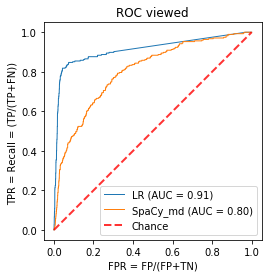

In [229]:
plot_roc_mat(Y_valid,res)

### Load model

In [319]:
output_dir='test'
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)


Loading from test
We are starving and we need urgently food: water, bread, milk {'POSITIVE': 0.8373962044715881, 'NEGATIVE': 0.16260382533073425}


In [329]:
test_text = "I am going to the concert of U2 in Zurich tomorrow"
doc = nlp2(test_text)
print(test_text, doc.cats)

I am going to the concert of U2 in Zurich tomorrow {'POSITIVE': 0.00011521164560690522, 'NEGATIVE': 0.9998847246170044}


In [326]:
test_set =X_test.to_list()
y_prob=[]

for n in range(0,len(test_set)):
    test = nlp2(test_set[n])
    y_prob.append( test.cats['POSITIVE']  )
    



In [330]:
y_prob=np.array(y_prob)
y_pred=y_prob>.5

print(classification_report(Y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3732
           1       0.64      0.58      0.61       478

    accuracy                           0.91      4210
   macro avg       0.79      0.77      0.78      4210
weighted avg       0.91      0.91      0.91      4210



In [331]:
print(confusion_matrix(Y_test,y_pred))

[[3574  158]
 [ 201  277]]
